![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/creativity.jpg)

# Dealing with very small datasets

In this kernel we will see some techniques to handle very small datasets, where the main challenge is to avoid overfitting.

1. <a href="#t1">Why small datasets lead to overfitting?</a>
2. <a href="#t2">Use simple models</a>
3. <a href="#t3">Beware the outliers</a>
4. <a href="#t4">Select the features</a>
5. <a href="#t5">Balance the dataset with synthetic samples (SMOTE)</a>
6. <a href="#t6">Combine models for the final submission</a>
7. <a href="#t7">References</a>

Let's load the data from the **Don't Overfit! II** competition:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

labels = train.columns.drop(['id', 'target'])
target = train['target']

print('Train rows:', train.shape[0])
print('Test rows:', test.shape[0])
print('Data columns:', test.columns.drop(['id']).shape[0])

Train rows: 250
Test rows: 19750
Data columns: 300


A visual inspection of the number of rows:

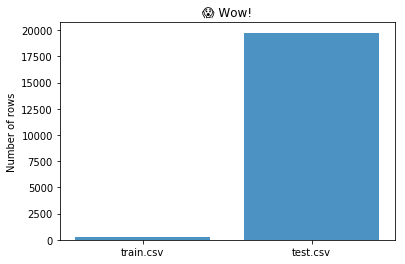

In [2]:
import matplotlib.pyplot as plt

d_names = ('train.csv', 'test.csv')
y_pos = range(len(d_names))
 
plt.bar(
    y_pos, 
    (train.shape[0], test.shape[0]), 
    align='center', 
    alpha=0.8
)
plt.xticks(y_pos, d_names)
plt.ylabel('Number of rows') 
plt.title('😱 Wow!')
plt.show()

<h1 id="t1">1. Why small datasets lead to overfitting?</h1>

The goal of a machine learning model is to **generalize** patterns in training data so that you can correctly predict new data that has never been presented to the model. Overfitting occurs when a model adjusts excessively to the training data, seeing patterns that do not exist, and consequently performing poorly in predicting new data:

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/under_over.png)
<center><strong>Source:</strong> <a href="https://medium.com/@shubhapatnim86/generalisation-training-validation-test-data-machine-learning-part-6-1de9dbb7d3d5">https://medium.com/@shubhapatnim86/generalisation-training-validation-test-data-machine-learning-part-6-1de9dbb7d3d5</a></center>

<br>

The fewer samples for training, the more models can fit our data. In an extreme example (a), for just one training point, any model will be able to "explain" it, however simple or complex the model may be. As we get to have more samples (b, c), fewer models are able to explain them:

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/few_samples.png)
<center><strong>Source:</strong> <a href="https://towardsdatascience.com/breaking-the-curse-of-small-datasets-in-machine-learning-part-1-36f28b0c044d">https://towardsdatascience.com/breaking-the-curse-of-small-datasets-in-machine-learning-part-1-36f28b0c044d</a></center>

<br>

That way, for a dataset with only 250 samples, we need to be very careful not to be fooled by overfitting. In this kernel we will see some tips that can help.

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/meme1.jpeg)

<h1 id="t2">2. Use simple models</h1>

As we saw, few samples allow several models to "explain" the data. By thinking graphically, complex models can make crazy curves that will almost perfectly explain the training data, but possibly will perform poorly over the test data.

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/overfitting_curve.png)
<center><strong>Source:</strong> <a href="https://bioinfo.iric.ca/overfitting-and-regularization/">https://bioinfo.iric.ca/overfitting-and-regularization/</a></center>

<br>

Avoid complex models with many parameters, thus limiting their generalization and possibility of overfitting. Regularization techniques like L1 and L2 also help make the models more conservative. For tree-based models, reducing their maximum depth also limits the model's ability to see patterns and non-existent relationships.

A good model to get started is Logistic Regression, a linear model used when the dependent variable (target) is categorical (classification tasks).

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/logisticregression.png)
<center><strong>Source:</strong> <a href="https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc">https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc</a></center>

<br>

In this model, we can control the regularization by means of the <code>penalty</code> and <code>C</code> parameters (inverse of regularization strength - smaller values specify stronger regularization) to deal with the overfitting:

In [3]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression(
    penalty='l1',
    C=0.1
)
m.fit(train[labels], target)
m.predict_proba(test[labels])[:,1]

array([0.73113342, 0.61589892, 0.64559318, ..., 0.45603746, 0.84490201,
       0.31434359])

For tree-based models like XGBoost, we can control the overfitting by tuning a series of parameters:

- Restricting the maximum depth of trees via <code>max_depth</code> (low values)
- Making the model more conservative via <code>gamma</code> and <code>eta</code> (high values)
- L1 and L2 regularization via <code>reg_alpha</code> and <code>reg_lambda</code> (high values)

In [4]:
from xgboost import XGBClassifier

m = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
m.fit(train[labels], target)
m.predict_proba(test[labels])[:,1]

array([0.7138114 , 0.5700851 , 0.48749483, ..., 0.29266763, 0.81729746,
       0.42823464], dtype=float32)

**Note that because it is a nonlinear model with several parameters, it tends to be more prone to overfitting than a simple linear model such as logistic regression.**

<h1 id="t3">3. Beware the outliers</h1>

Outliers are extreme values that fall a long way outside of the other observations. In a small dataset, the impact of an outlier can be much greater, since it will have a heavy weight for the model:

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/outlier.png)
<center><strong>Source:</strong> <a href="https://becominghuman.ai/day-7-data-cleaning-all-that-you-need-to-know-about-it-23b05738abe7">https://becominghuman.ai/day-7-data-cleaning-all-that-you-need-to-know-about-it-23b05738abe7</a></center>

<br>

The scikit-learn library has several implementations of outliers detection techniques:

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/outl_detection.png)
<center><strong>Source:</strong> <a href="https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html">https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html</a></center>

<br>

Let's do an experiment with the <code>IsolationForest</code> technique, which uses random forests for efficient detection of outliers in high-dimensional datasets. From scikit-learn documentation:

> The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
> 
> Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.
> 
> This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/isolation_forest.jpg)
<center><strong>Source:</strong> <a href="https://www.slideshare.net/mlvlc/l14-anomaly-detection">https://www.slideshare.net/mlvlc/l14-anomaly-detection</a></center>

<br>

Let's score each sample of our dataset using a isolation forest (the lower, the more abnormal):

In [5]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(n_jobs=-1, random_state=1)
isf.fit(train[labels], train['target'])

print(isf.score_samples(train[labels]))

[-0.43469812 -0.41975972 -0.43645204 -0.41547635 -0.43619105 -0.45387404
 -0.44501066 -0.42808743 -0.42391595 -0.42821109 -0.42663739 -0.42636454
 -0.43802452 -0.43881928 -0.42235859 -0.43685353 -0.42252529 -0.42698686
 -0.43146739 -0.43967397 -0.44154264 -0.43686939 -0.42246759 -0.4525844
 -0.43240325 -0.41816402 -0.41772435 -0.41816617 -0.44642832 -0.43005119
 -0.43868305 -0.41364373 -0.43876162 -0.42955655 -0.44890674 -0.42345201
 -0.43351493 -0.44406837 -0.4353762  -0.43473154 -0.4204892  -0.4370371
 -0.43454054 -0.42305028 -0.42845387 -0.44410595 -0.43576584 -0.41683766
 -0.42368301 -0.41962975 -0.44162676 -0.45019865 -0.43763141 -0.41514594
 -0.43407452 -0.42406518 -0.43057011 -0.41716011 -0.43461005 -0.42653133
 -0.44000386 -0.45187644 -0.44434114 -0.44041757 -0.43705451 -0.43975507
 -0.42971908 -0.4486313  -0.41805613 -0.41747817 -0.41891668 -0.43978058
 -0.43669433 -0.43036516 -0.43125644 -0.43741219 -0.42797231 -0.42653472
 -0.4231017  -0.41581038 -0.43063687 -0.44138784 -0.4

Now, let's predict the outliers (1 for inliers, -1 for outliers):

In [6]:
isf.predict(train[labels])

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


array([ 1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

**Beware, with few samples, it becomes a challenge to adjust the algorithms to correctly identify the outliers.**

<h1 id="t4">4. Select the features</h1>

While removing outliers consists of deleting rows from the dataset, feature selection consists of deleting columns that do not contribute to the prediction. There is a wide variety of methods, such as analysis of its correlation with the target, importance analysis and recursive elimination.

Let's see an example of how to identify the most relevant features for classification using a tree model:

In [7]:
from sklearn.ensemble import ExtraTreesClassifier

TOP_FEATURES = 15

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
forest.fit(train[labels], train['target'])

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]

print('Top features:')
for f in range(TOP_FEATURES):
    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))

Top features:
1. feature 33 (0.041746)
2. feature 65 (0.022398)
3. feature 117 (0.013911)
4. feature 217 (0.010103)
5. feature 189 (0.009902)
6. feature 91 (0.009249)
7. feature 39 (0.008257)
8. feature 73 (0.008089)
9. feature 4 (0.007575)
10. feature 201 (0.007043)
11. feature 220 (0.007042)
12. feature 214 (0.006762)
13. feature 16 (0.006686)
14. feature 119 (0.006643)
15. feature 268 (0.006589)


We can plot a chart of the importances:

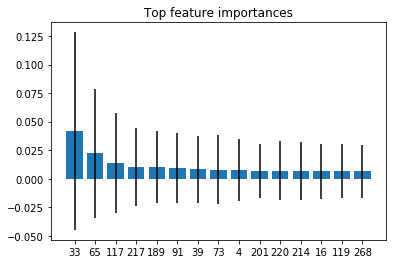

In [8]:
plt.figure()
plt.title('Top feature importances')
plt.bar(
    range(TOP_FEATURES), 
    importances[indices],
    yerr=std[indices], 
)
plt.xticks(range(TOP_FEATURES), indices)
plt.show()

In the next example, we will try to identify the most important features by successively training a model and recursively eliminating those that do not contribute to a good final solution (according to the selected model).

We will use the recursive feature elimination <code>RFE</code> from the scikit-learn library and the <code>XGBClassifier</code> model:

In [9]:
from sklearn.feature_selection import RFE

rfe = RFE(XGBClassifier(n_jobs=-1, random_state=1))

rfe.fit(train[labels], train['target'])

print('Selected features:')
print(labels[rfe.support_].tolist())

Selected features:
['0', '1', '4', '6', '7', '9', '11', '12', '14', '16', '17', '18', '20', '21', '24', '25', '28', '32', '33', '35', '37', '38', '39', '43', '45', '46', '48', '49', '50', '55', '57', '63', '65', '66', '70', '73', '75', '80', '82', '83', '90', '91', '93', '95', '96', '100', '101', '102', '103', '106', '107', '108', '110', '111', '112', '114', '116', '117', '120', '121', '123', '126', '129', '131', '132', '133', '134', '141', '147', '148', '149', '150', '151', '153', '157', '160', '164', '165', '166', '167', '168', '170', '172', '173', '176', '177', '179', '183', '185', '189', '193', '194', '195', '198', '199', '201', '202', '204', '205', '208', '209', '214', '216', '217', '219', '220', '225', '226', '227', '228', '230', '231', '232', '234', '237', '241', '242', '244', '245', '251', '253', '254', '255', '257', '258', '259', '260', '261', '266', '268', '269', '272', '273', '275', '276', '277', '279', '280', '281', '282', '285', '286', '289', '291', '292', '293', '295', '2

**Caution: for a very small dataset, very robust local validation is required to determine whether or not a feature contributes to the final solution. **

<h1 id="t5">5. Balance the dataset with synthetic samples (SMOTE)</h1>

<br>

Let's look at the distribution of target values:

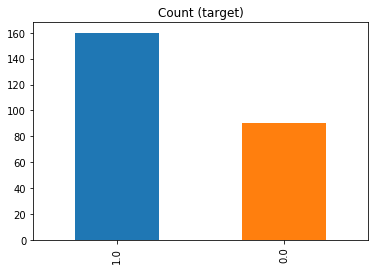

In [10]:
train['target'].value_counts().plot(kind='bar', title='Count (target)');

In addition to being extremely small, our training dataset has the unbalanced <code>target</code> binary variable, which can undermine some models' predictability. We will perform an oversampling, which consists of creating new samples to increase the <code>0</code> minority class. For this we will use the SMOTE technique.

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)
<center><strong>Source:</strong> <a href="https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets">https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets</a></center>

<br>

We'll use the SMOTE implementation from the library <code>imbalanced-learn</code>, with the parameter <code>ratio='minority'</code> to resample the minority class:

Using TensorFlow backend.


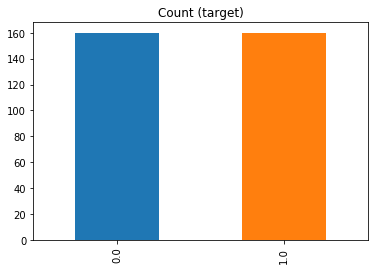

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(train[labels], train['target'])

df = pd.DataFrame(X_sm, columns=labels)
df['target'] = y_sm

df['target'].value_counts().plot(kind='bar', title='Count (target)');

<h1 id="t6">6. Combine models for the final submission</h1>

Combine the prediction of several models or the same model with different values of hyperparameters reduces variance and enhances generalization.

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/combine.jpg)
<center><strong>Source:</strong> <a href="https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89">https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89</a></center>

<br>

Often, combining weak models that are poorly correlated with each other can lead to superior results than a strong individual model. There are several ways to do this. The simplest is to perform a weighted average of the various predictions:

In [12]:
models = [
    LogisticRegression(),
    XGBClassifier(max_depth=2)
]

preds = pd.DataFrame()
for i, m in enumerate(models):
    m.fit(train[labels], target),
    preds[i] = m.predict_proba(test[labels])[:,1]

weights = [1, 0.3]
preds['weighted_pred'] = (preds * weights).sum(axis=1) / sum(weights)
preds.head()

,0,1,weighted_pred
0,0.087555,0.774624,0.246110
1,0.012161,0.615365,0.151362
2,0.403013,0.581467,0.444194
3,0.999589,0.967713,0.992233
4,0.262142,0.856254,0.399245


Another more sophisticated way of combining predictions is the use of a meta-classifier, which receives as input the prediction of other classifiers, and performs the final predict. From the <code>mlxtend</code> library documentation:

> Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/stack.png)
<center><strong>Source:</strong> <a href="http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/">http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/</a></center>

<br>

As an example, we will use the <code>StackingClassifier</code> of the <code>mlxtend</code> library:

In [13]:
from mlxtend.classifier import StackingClassifier

m = StackingClassifier(
    classifiers=[
        LogisticRegression(),
        XGBClassifier(max_depth=2)
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

m.fit(train[labels], target),
preds['stack_pred'] = m.predict_proba(test[labels])[:,1]
preds.head()

,0,1,weighted_pred,stack_pred
0,0.087555,0.774624,0.246110,0.298072
1,0.012161,0.615365,0.151362,0.137342
2,0.403013,0.581467,0.444194,0.492656
3,0.999589,0.967713,0.992233,0.987880
4,0.262142,0.856254,0.399245,0.579377


![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/mem2.jpg)

<h1 id="t7">References</h1>

**Overfitting:**
* IRIC's Bioinformatics Platform. Overfitting and Regularization. https://bioinfo.iric.ca/overfitting-and-regularization/
* PATNI, Shubham. Generalisation, Training-Validation & Test data. Machine Learning- Part 6. https://medium.com/@shubhapatnim86/generalisation-training-validation-test-data-machine-learning-part-6-1de9dbb7d3d5
* Rants on Machine Learning. What to do with “small” data? https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89
* Towards Data Science. Breaking the curse of small datasets in Machine Learning: Part 1. https://towardsdatascience.com/breaking-the-curse-of-small-datasets-in-machine-learning-part-1-36f28b0c044d

**Models:**
* scikit-learn. LogisticRegression. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* Towards Data Science. Logistic Regression — Detailed Overview. https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc
* XGBoost. XGBoost Parameters. https://xgboost.readthedocs.io/en/latest/parameter.html

**Outlier detection:**
* Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM‘08. Eighth IEEE International Conference on.
* Machine Learning Valencia. Anomaly Detection. Valencian Summer School 2015. https://www.slideshare.net/mlvlc/l14-anomaly-detection
* scikit-learn. Novelty and Outlier Detection. https://scikit-learn.org/stable/modules/outlier_detection.html
* VADALI, SaiGayatri.Day 7: Data cleaning — All you need to know about it. https://becominghuman.ai/day-7-data-cleaning-all-that-you-need-to-know-about-it-23b05738abe7

**Feature selection:**
* scikit-learn. Feature selection. https://scikit-learn.org/stable/modules/feature_selection.html

**SMOTE**
* ALENCAR, Rafael. Resampling strategies for imbalanced datasets. https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
* Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002)
* imbalanced-learn. https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

**Stacking**
* mlxtend. StackingClassifier. http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/
* Tang, J., S. Alelyani, and H. Liu. "Data Classification: Algorithms and Applications." Data Mining and Knowledge Discovery Series, CRC Press (2015): pp. 498-500.
* Wolpert, David H. "Stacked generalization." Neural networks 5.2 (1992): 241-259.